# Proc33ssor Prototype

# Proc33ssor Prototype

## Overview

**Proc33ssor** is a standalone application designed to analyze and catalog a large archive of images on a local machine. This prototype focuses on processing a single image to generate detailed metadata and then extending the process to handle multiple images. The metadata will be stored in a local database, enabling efficient searching and retrieval of images based on various criteria.

## Features

1. **Image Tagging:**
   - Generate descriptive tags for images using a locally hosted Large Language Model (LLM).
   - **Technologies:** Hugging Face Transformers, spaCy

2. **Basic Data Analysis:**
   - Analyze and display metrics such as value distribution, color scheme, and color gamut.
     - [x] Read Image Metadata
     - [x] Grayscale Value Distribution: Histogram of pixel values, after image has been converted to BW.
     - [ ] 2 Value Posterize Value Distribution: Histogram of pixel values, after image has been converted to 2 colors.
     - [ ] Full Color Distribution: Histogram of color values.
     - [ ] Image Proportion: Aspect ratio of the image.
   - Additional metrics: edge detection, texture analysis, and histogram analysis.
   - **Technologies:** OpenCV, scikit-image

3. **Unique Identifier Embedding:**
   - Embed a unique identifier into the byte data of each image to record authorship and identity.
   - **Technologies:** Pillow, Steganography Libraries (e.g., Stegano)

4. **Additional Metrics:**
   - Detect dominant colors and objects in images.
   - **Technologies:** TensorFlow/Keras, EXIFRead

5. **Database Storage:**
   - Store and retrieve image metadata and version history in a local database.
   - **Technologies:** SQLite

6. **Natural Language Search:**
   - Implement basic search functionality to find images based on written prompts.
   - **Technologies:** Elasticsearch

7. **Version Control:**
   - Maintain a `proc33ssVersion` value embedded in each image and store version history in the database.
   - Track and store the current version in an environment variable on the host system.


## 2. Pixel Data Analysis

### 2.1 Read Image Metadata

In [1]:
# pip install exifread
import exifread
from PIL import Image
import re
from pprint import pprint


def read_metadata(image_path):
    # Using Pillow to read basic metadata
    image = Image.open(image_path)
    pillow_metadata = image.info
    
    # Using exifread to read EXIF metadata
    with open(image_path, 'rb') as img_file:
        exif_metadata = exifread.process_file(img_file)
    
    # Combine both metadata into a single dictionary
    combined_metadata = {
        "pillow_metadata": pillow_metadata,
        "exif_metadata": {tag: str(exif_metadata[tag]) for tag in exif_metadata.keys()}
    }
    
    return combined_metadata

def extract_parameters(description):
    # Regular expression to find parameters like --param value
    pattern = re.compile(r'--(\w+)\s+([\w:]+)')
    matches = pattern.findall(description)
    
    params = {key: value for key, value in matches}
    return params

def extract_job_id(description):
    # Regular expression to find Job ID
    pattern = re.compile(r'Job ID:\s+([\w-]+)')
    match = pattern.search(description)
    
    if match:
        return match.group(1)
    return None

def clean_metadata(metadata):
    # Extract relevant information
    cleaned_metadata = {
        key: metadata['pillow_metadata'][key] for key in metadata['pillow_metadata']
        if key in ['Creation Time', 'Author', 'Description']
    }
    
    # Extract parameters from description if available
    if 'Description' in cleaned_metadata:
        description = cleaned_metadata['Description']
        
        # Extract parameters
        params = extract_parameters(description)
        cleaned_metadata.update(params)
        
        # Extract Job ID
        job_id = extract_job_id(description)
        if job_id:
            cleaned_metadata['Job ID'] = job_id
        
        # Remove the parameters and Job ID from the description
        cleaned_metadata['Description'] = re.sub(r'--\w+\s+[\w:]+', '', description)
        cleaned_metadata['Description'] = re.sub(r'Job ID:\s+[\w-]+', '', cleaned_metadata['Description']).strip()
    
    return cleaned_metadata

# Example usage
image_path = './images/image_05.png'  # Update with the path to your image
metadata = read_metadata(image_path)

# Clean the metadata
cleaned_metadata = clean_metadata(metadata)

# Print cleaned metadata
pprint(cleaned_metadata)

PNG file does not have exif data.


{'Author': 'thirty.thr3',
 'Creation Time': 'Sun, 02 Jun 2024 11:25:47 GMT',
 'Description': 'cowboy knight templar + in Babylonian New Mexico, circa year '
                '1888, in the style of afro-fantasy hollywood fantasy + 16k '
                'UE5 graphics + CGI cinematic movie screenshot',
 'Job ID': '9f5c7ef9-b731-440d-b3f8-82221e1630e2',
 'ar': '1:1',
 'chaos': '15'}


### 2.2 Value Distribution Analysis

### Introduction

In image processing, analyzing the pixel value distribution is a fundamental task that helps in understanding the intensity variation across an image. The pixel value distribution, also known as the histogram of pixel intensities, provides insights into the contrast, brightness, and intensity range of the image. This metric is particularly useful for applications such as image enhancement, thresholding, and image segmentation.

### What is Value Distribution?

The value distribution of an image refers to the frequency of occurrence of each pixel intensity value within the image. For a grayscale image, the pixel values range from 0 (black) to 255 (white). By examining how often each of these values occurs, we can gather valuable information about the image's overall appearance and characteristics.

### Data Structure

The output of the value distribution analysis is a dictionary where the keys represent the pixel intensity values (ranging from 0 to 255), and the values represent the frequency of each pixel intensity within the image. This data structure is not only easy to interpret but also convenient for storage in a database for future reference and analysis.

### Example

Consider a simple grayscale image with the following pixel values:

```
[[  0, 255, 128],
 [128, 128,  64],
 [255,   0,  64]]
```

The value distribution for this image would be:

```
{
  0: 2,
  64: 2,
  128: 3,
  255: 2
}
```

In this example, the pixel intensity value `0` appears twice, `64` appears twice, `128` appears three times, and `255` appears twice. This histogram-like representation provides a clear view of how pixel values are distributed across the image.

### Visualization

To enhance understanding, we can visualize the value distribution as a bar chart. The x-axis represents the pixel intensity values, and the y-axis represents the frequency of each value. This visual representation helps in quickly identifying patterns such as whether the image is predominantly dark, bright, or has a good contrast.

### Implementation

Calculate and visualize the value distribution of a grayscale image:

1. **Load and display the image:**
   - Use OpenCV to load the image in grayscale mode.
   - Display the image using matplotlib.

2. **Calculate the value distribution:**
   - Flatten the image array to a one-dimensional list of pixel values.
   - Use the `Counter` class from the `collections` module to count the frequency of each pixel value.
   - Convert the `Counter` object to a dictionary for easy storage and retrieval.

3. **Visualize the value distribution:**
   - Prepare the data for plotting.
   - Use matplotlib to create a bar chart representing the pixel value distribution.

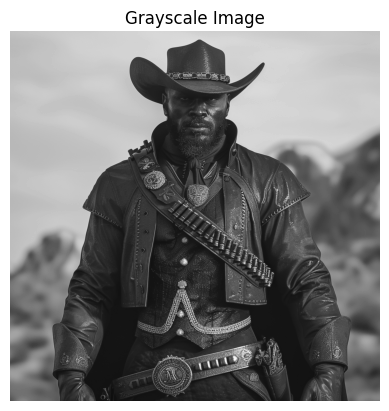

In [2]:
# pip install opencv-python matplotlib numpy

import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Load the image using OpenCV
image_path = './images/image_05.png'  # Update with the path to your image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale

# Display the image
plt.imshow(image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

In [3]:
# ⭐️ Calculate the value distribution of the image ⭐️
from pprint import pprint

def calculate_value_distribution(image):
    # Flatten the image array and calculate the frequency of each pixel value
    flat_image = image.flatten()
    value_counts = Counter(flat_image)
    
    # Convert the Counter object to a dictionary for easy future storage
    value_distribution = dict(value_counts)
    
    return value_distribution

# Calculate the value distribution
value_distribution = calculate_value_distribution(image)

# Print the value distribution (for checking the output)
pprint(value_distribution)

{0: 61,
 1: 15,
 2: 28,
 3: 18,
 4: 28,
 5: 24,
 6: 31,
 7: 31,
 8: 42,
 9: 37,
 10: 60,
 11: 94,
 12: 64,
 13: 116,
 14: 193,
 15: 294,
 16: 518,
 17: 1030,
 18: 3136,
 19: 14156,
 20: 25342,
 21: 15846,
 22: 8480,
 23: 8357,
 24: 8636,
 25: 8261,
 26: 8093,
 27: 8504,
 28: 8633,
 29: 9157,
 30: 9177,
 31: 8675,
 32: 8074,
 33: 7727,
 34: 7855,
 35: 7654,
 36: 7880,
 37: 7900,
 38: 8054,
 39: 7734,
 40: 7645,
 41: 7659,
 42: 7699,
 43: 7667,
 44: 7865,
 45: 7543,
 46: 7758,
 47: 8040,
 48: 7819,
 49: 8005,
 50: 8067,
 51: 7912,
 52: 7757,
 53: 7616,
 54: 7558,
 55: 7391,
 56: 7236,
 57: 7343,
 58: 7340,
 59: 6764,
 60: 6577,
 61: 6345,
 62: 6013,
 63: 5917,
 64: 5866,
 65: 5930,
 66: 5876,
 67: 5786,
 68: 5585,
 69: 5439,
 70: 5375,
 71: 5131,
 72: 5062,
 73: 4942,
 74: 4897,
 75: 4996,
 76: 5018,
 77: 4881,
 78: 5118,
 79: 5331,
 80: 5393,
 81: 5639,
 82: 5455,
 83: 5360,
 84: 5143,
 85: 4948,
 86: 4798,
 87: 4825,
 88: 4644,
 89: 4463,
 90: 4530,
 91: 4382,
 92: 4231,
 93: 4024,
 94

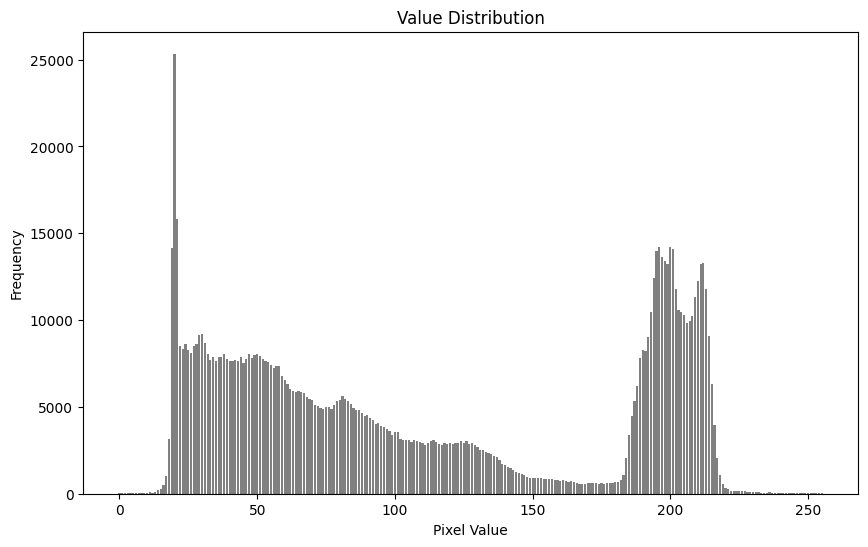

In [4]:
def plot_value_distribution(value_distribution):
    # Prepare data for plotting
    values = list(value_distribution.keys())
    counts = list(value_distribution.values())
    
    # Plot the value distribution
    plt.figure(figsize=(10, 6))
    plt.bar(values, counts, color='gray')
    plt.title('Value Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

# Plot the value distribution
plot_value_distribution(value_distribution)
